# Importing the dataset

In [ ]:
import os
os.chdir('/content/drive/My Drive/Capstone')

In [ ]:
import pandas as pd
df = pd.read_excel('fiscal_y1.xlsx')

# Text lengths

The idea is to find out the most frequent text lengths across the dataset. This helps in deciding the maximum length of padded sequences for neural networks. In the table below, the text length of 25 appears the most frequent.

In [ ]:
from collections import OrderedDict 
text_lengths = {}

for index, row in df.iterrows():
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description'])
  length = len(text)
  if length not in text_lengths:
    text_lengths[length] = 0
  text_lengths[length] += 1

new_text_lengths = pd.DataFrame(sorted(text_lengths.items(),key=lambda x: x[1],reverse=True)) #sort in descendi
new_text_lengths.columns = ['Text Length', 'Frequency Count']
new_text_lengths.head()

,Text Length,Frequency Count
0,25,3680
1,33,3048
2,45,2946
3,31,2903
4,27,2586


Get the statistics of the text lengths across all rows. The mean here is 65, which means that the sequences can be padded to 70. 

In [ ]:
text_lengths = []

for index, row in df.iterrows():
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description'])
  length = len(text)
  text_lengths.append(length)

pd.Series(text_lengths).describe()

count    108377.000000
mean         65.245947
std          71.831273
min           5.000000
25%          30.000000
50%          47.000000
75%          75.000000
max        3449.000000
dtype: float64

# Class Analysis

This is to understand the distribution of the number of records each class have and to find out the number of classes in the dataset. The mean is 12, which means that on average, a class has 12 records. This is useful when we want to remove the minority classes later.

Clean up the labels. Some have whitespaces and \t and \n.

In [ ]:
for index, row in df.iterrows():
  label = str(row['Commodity Title'])
  if '\t' in label:
    df.at[index, 'Commodity Title'] = str(row['Commodity Title']).replace('\t', '')
  if '\n' in label:
    df.at[index, 'Commodity Title'] = str(row['Commodity Title']).replace('\n', '')
  df.at[index, 'Commodity Title'] = str(row['Commodity Title']).strip(' ')

In [ ]:
unique_classes = df['Commodity Title'].unique()

unc = {}
for i in unique_classes:
  unc[i] = df[df['Commodity Title'] == i].shape[0]

pd.Series(list(unc.values())).describe()

count    8362.000000
mean       12.960655
std        60.395010
min         1.000000
25%         1.000000
50%         3.000000
75%         8.000000
max      2648.000000
dtype: float64

Furthermore, we have done a visualisation on the distribution of the number of records the classes have. This is to show the huge imbalance. We have plotted the average number of records the top n% of the classes have.

In [ ]:
import numpy as np

lst = list(unc.values())
sorted_lst = sorted(lst) #sort in ascending order

In [ ]:
from copy import deepcopy
#836: split the entire values into roughly 10 parts
counter = 1
index = 0
scores = [] #each element will contain the values for each percentile
tmp_lst = deepcopy(sorted_lst)
while tmp_lst:
  if counter == 1:
    scores.append([])
  scores[index].append(tmp_lst[0])
  tmp_lst = tmp_lst[1:]
  counter += 1
  if counter == 836:
    counter = 1
    index += 1

In [ ]:
height = [sum(i) / len(i) for i in scores]
bars = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

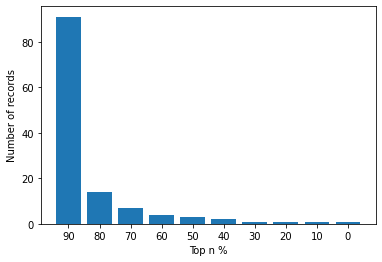

In [ ]:
# Create bars
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.xlabel("Top n %")
plt.ylabel("Number of records")

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(bar_plot)
# Show graphic
plt.show()

# Word Frequency Analysis

This is to find out the words that occur the most frequently in the dataset. The graph below shows the top 20 words which appear the most frequently.

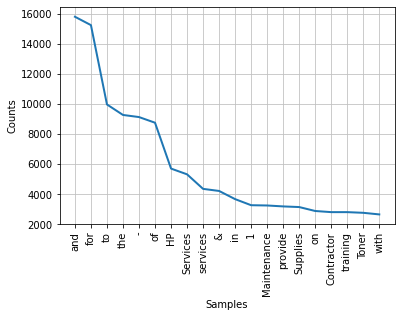

In [ ]:
import nltk

all_text = []
for index, row in df.iterrows():
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description'])
  text = text.split()
  for word in text:
    all_text.append(word)

fdist = nltk.FreqDist(all_text)
fdist.plot(20)

# N-grams Analysis

N-grams represent the phrases of words that appear in the dataset. For example, unigram means individual words, bigram means phrases of 2 words and trigrams means phrases of 3 words. The plots below show the top 15 words/phrases for each level, unigram, bigram and trigram.

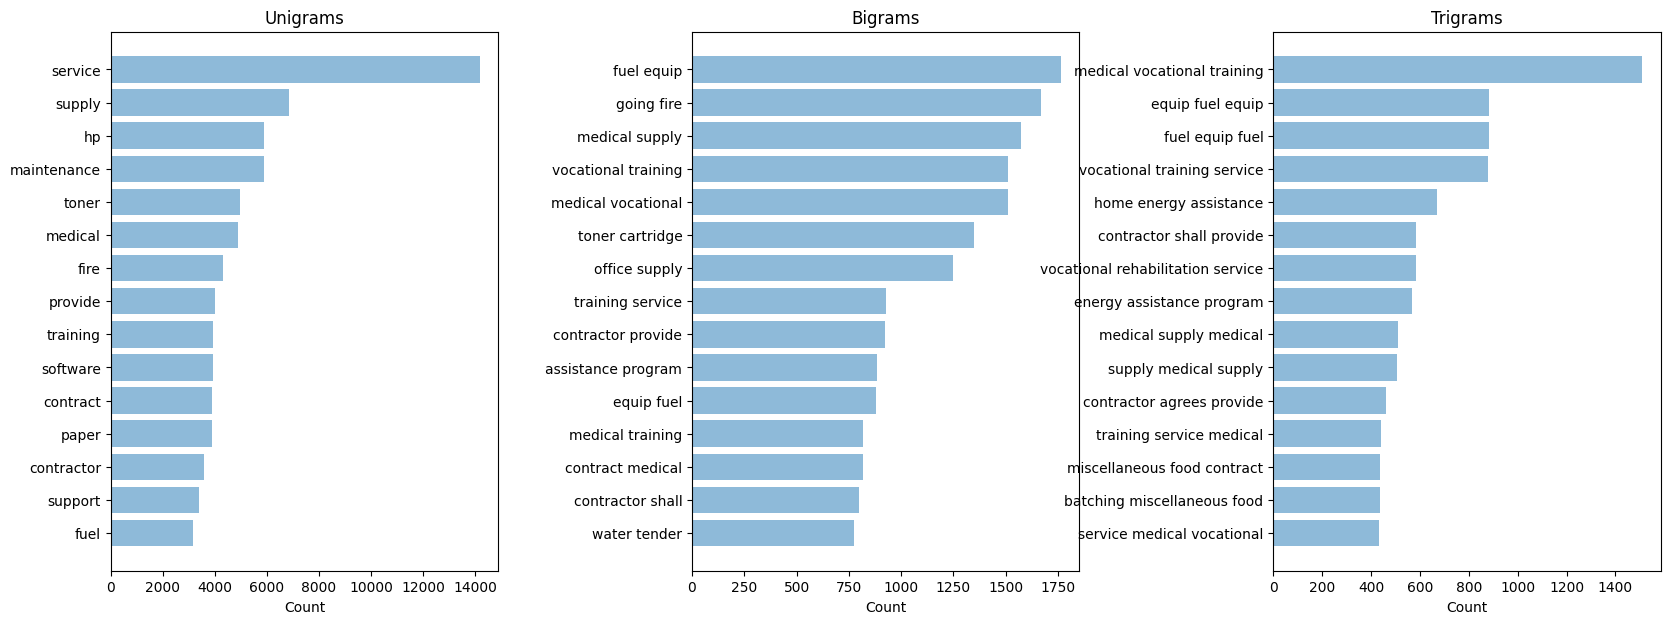

In [ ]:
import pandas as pd
import re
from nltk.util import ngrams
from collections import Counter
import csv
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

def documentNgrams(documents, size):
    ngrams_all = []
    for document in documents:
        tokens = document.split()
        if len(tokens) <= size:
            continue
        else:
            output = list(ngrams(tokens, size))
        for ngram in output:
            ngrams_all.append(" ".join(ngram))
    cnt_ngram = Counter()
    for word in ngrams_all:
        cnt_ngram[word] += 1
    temp = pd.DataFrame.from_dict(cnt_ngram, orient='index').reset_index()
    temp = temp.rename(columns={'index':'words', 0:'count'})
    temp = temp.sort_values(by='count', ascending=False)
    temp = temp.head(15) #showing top 15 words/phrases for each gram
    temp = temp.sort_values(by='count')
    return(temp)

def plotNgrams(documents):
    unigrams = documentNgrams(documents, 1)
    bigrams = documentNgrams(documents, 2)
    trigrams = documentNgrams(documents, 3)
    
    # Set plot figure size
    fig = plt.figure(figsize = (20, 7))
    plt.subplots_adjust(wspace=.5)

    ax = fig.add_subplot(131)
    ax.barh(np.arange(len(unigrams['words'])), unigrams['count'], align='center', alpha=.5)
    ax.set_title('Unigrams')
    plt.yticks(np.arange(len(unigrams['words'])), unigrams['words'])
    plt.xlabel('Count')

    ax2 = fig.add_subplot(132)
    ax2.barh(np.arange(len(bigrams['words'])), bigrams['count'], align='center', alpha=.5)
    ax2.set_title('Bigrams')
    plt.yticks(np.arange(len(bigrams['words'])), bigrams['words'])
    plt.xlabel('Count')

    ax3 = fig.add_subplot(133)
    ax3.barh(np.arange(len(trigrams['words'])), trigrams['count'], align='center', alpha=.5)
    ax3.set_title('Trigrams')
    plt.yticks(np.arange(len(trigrams['words'])), trigrams['words'])
    plt.xlabel('Count')

    plt.show()

cleaned_texts = []
for index, row in df.iterrows():
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description'])
  cleaned_texts.append(text)

plotNgrams(cleaned_texts)

# Word Cloud for each class

To find out what are the words which appear the most frequently for each class. The higher the frequency of the word, the larger the size of the word. The plot below shows the word clouds for the first 3 classes.

Combine the item name and item description for each row

In [ ]:
texts = []
for index, row in df.iterrows():
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    texts.append('')
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description'])
  texts.append(text)

df['Text'] = texts

Concatenate the texts for all rows in the same class together

In [ ]:
unique_classes = df['Commodity Title'].unique()
unique_classes_text = {}

for i in unique_classes:
  sub_df = df[df['Commodity Title'] == i]
  tot_text = ' '.join(i for i in list(sub_df['Text'].values))
  unique_classes_text[i] = tot_text

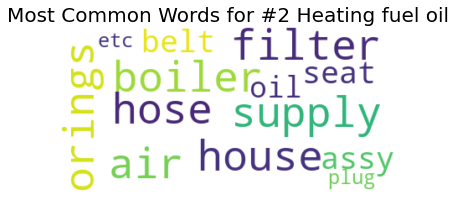

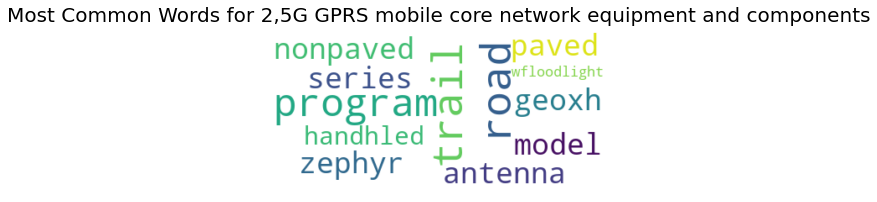

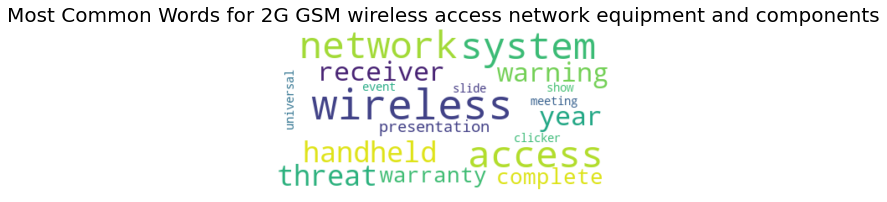

In [ ]:
from wordcloud import *

#show word cloud for the first 3 classes
counter = 0
for curr_class in unc:
  allwords = unique_classes_text[curr_class]
  wc = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(allwords)
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.title('Most Common Words for ' + curr_class, fontsize=20)
  plt.show()
  counter += 1
  if counter == 3:
    break


# Word Frequency Analysis for each class

To understand the cumulative frequency distribution of words for each class. This plot identifies the most frequent words for each class. This is similar to the word cloud above. The difference is that this plot gives a more mathematical representation of the words while the word cloud gives a more pictorial representation of the words.

Total Words: 13961


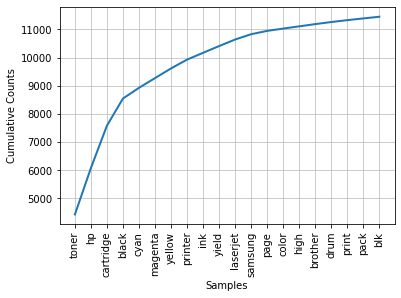

Total Words: 15002


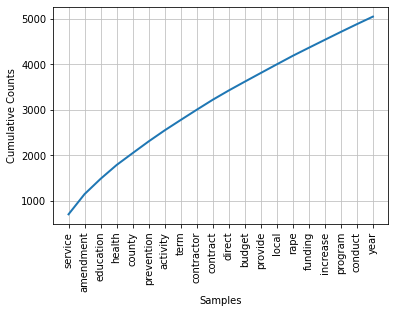

Total Words: 8352


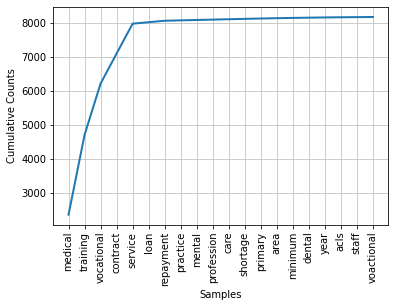

In [ ]:
pop_classes = df['Commodity Title'].values[:3]

for curr_class in pop_classes:
  sub_df = df[df['Class'] == curr_class]
  allwords = []
  for index, row in sub_df.iterrows():
    text = row['Text'].split()
    allwords.extend(text)
  print("Total Words: " + str(len(allwords)))
  fd = nltk.FreqDist(allwords)
  fd.plot(20, cumulative = True)

# Non-English Words Analysis

To identify what are the most common non-english words. These words could be typos or abbreviations. The words are being checked against the words list from the nltk corpus. That list is incomplete so some of the words may be deemed non-english words when they are actually english words. The table shows the top 20 non-english words sorted in descending order by frequency. Hp which probably stands for handphone, appears the most frequent.

In [ ]:
import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())

Count the frequency of non-english words in the entire dataset

In [ ]:
non_english_words = {}
for index, row in df.iterrows():
  txt = row['Text']
  for i in txt.split():
    if i not in words:
      if i not in non_english_words:
        non_english_words[i] = 0
      non_english_words[i] += 1

In [ ]:
new_df = pd.DataFrame(sorted(non_english_words.items(),key=lambda x: x[1],reverse=True))
new_df.columns = ['Non-English Word', 'Frequency Count']
new_df.head(20)

,Non-English Word,Frequency Count
0,hp,5905
1,software,3928
2,california,1895
3,desktop,1168
4,misc,898
5,fy,769
6,samsung,745
7,onsite,678
8,pc,663
9,agrees,661
